# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [10]:
import pyrosetta.distributed

In [11]:
import tmol.tests.data

In [12]:
import tmol.system.io
import tmol.score
import torch

In [13]:
import numba.cuda

In [18]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [19]:
decoys = tmol.tests.data.structures_bysize()

In [20]:
from tmol.tests.benchmark import subfixture, make_fixture, stat_frame

def benchmark_rosetta_scores(decoys):
    stats = []
    
    for n, d in decoys.items():
        logging.info(n)
        work_pose = d.stripped_pose.pose
        
        fixture = make_fixture("score", stats.append, nres=len(work_pose.residues), model = n)
        
        logging.info("Rosetta")
        #fsf = pyrosetta.get_score_function()
        #def rosetta_noclear():
        #    return fsf(work_pose)
        #
        #def rosetta_clear():
        #    work_pose.energies().clear()
        #    return fsf(work_pose)
        #
        #null_sf = pyrosetta.get_score_function()
        #for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        #    null_sf.set_weight(v, 0)
        #
        #def rosetta_null():
        #    work_pose.energies().clear()
        #    return null_sf(work_pose)
        #
        #def rosetta_full():
        #    work_pose.energies().clear_energies()
        #    return fsf(work_pose)
        
        atr_rep_sf = pyrosetta.get_score_function()
        for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
            if k not in ("fa_atr", "fa_rep"):
                atr_rep_sf.set_weight(v, 0)
                
        @subfixture(fixture) 
        def rosetta_atr_rep():
            work_pose.energies().clear()
            return atr_rep_sf(work_pose)
        
        logging.info("TMol")
        @reactive_attrs
        class TMolLJLK(
            tmol.score.ljlk.LJLKScoreGraph,
            tmol.score.interatomic_distance.BlockedInteratomicDistanceGraph,
            tmol.score.coordinates.CartesianAtomicCoordinateProvider,
            tmol.score.bonded_atom.BondedAtomScoreGraph,
            tmol.score.device.TorchDevice,
        ):
            pass

        tms_cpu = TMolLJLK.build_for(d.tmol_system)
        tms_cpu.intra_score().total
        
        @subfixture(fixture)
        def tmol_ljlk_cpu():
            tms_cpu.coords = tms_cpu.coords
            return float(tms_cpu.intra_score().total)
        
        # Bypass errors w/ cuda memory
        if len(work_pose.residues) > 500:
            continue
        
        tms_cuda = TMolLJLK.build_for(d.tmol_system, device=torch.device("cuda"))
        tms_cuda.intra_score().total
        
        @subfixture(fixture)
        def tmol_ljlk_cuda():
            tms_cuda.coords = tms_cuda.coords
            return float(tms_cuda.intra_score().total)
        
        del tms_cuda
        torch.cuda.empty_cache()
        
        logging.info(f"rosetta: {rosetta_atr_rep} cpu: {tmol_ljlk_cpu} cuda: {tmol_ljlk_cuda}")
        
    return stats

In [21]:
rosetta_score_results = benchmark_rosetta_scores(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:Rosetta
INFO:root:TMol
INFO:root:rosetta: -1653.4115141856676 cpu: 2026.47900390625 cuda: 2026.479248046875
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:TMol
INFO:root:rosetta: -954.3679023401932 cpu: -20.2642822265625 cuda: -20.2642822265625
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:Rosetta
INFO:root:TMol
INFO:root:rosetta: -1119.8932213914081 cpu: 72.33038330078125 cuda: 72.33038330078125
INFO:root:BYSIZE_300_RES_6F8B
INFO:root:Rosetta
INFO:root:TMol
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:root:rosetta: -1595.3013226696185 cpu: nan cuda: nan
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:Rosetta
INFO:root:TMol
INFO:root:rosetta: -440.40303847870354 cpu: -37.869171142578125 cuda: -37.869232177734375
INFO:root:BYSIZE_055_

In [22]:
from matplotlib import pyplot
import seaborn
import pandas

In [23]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

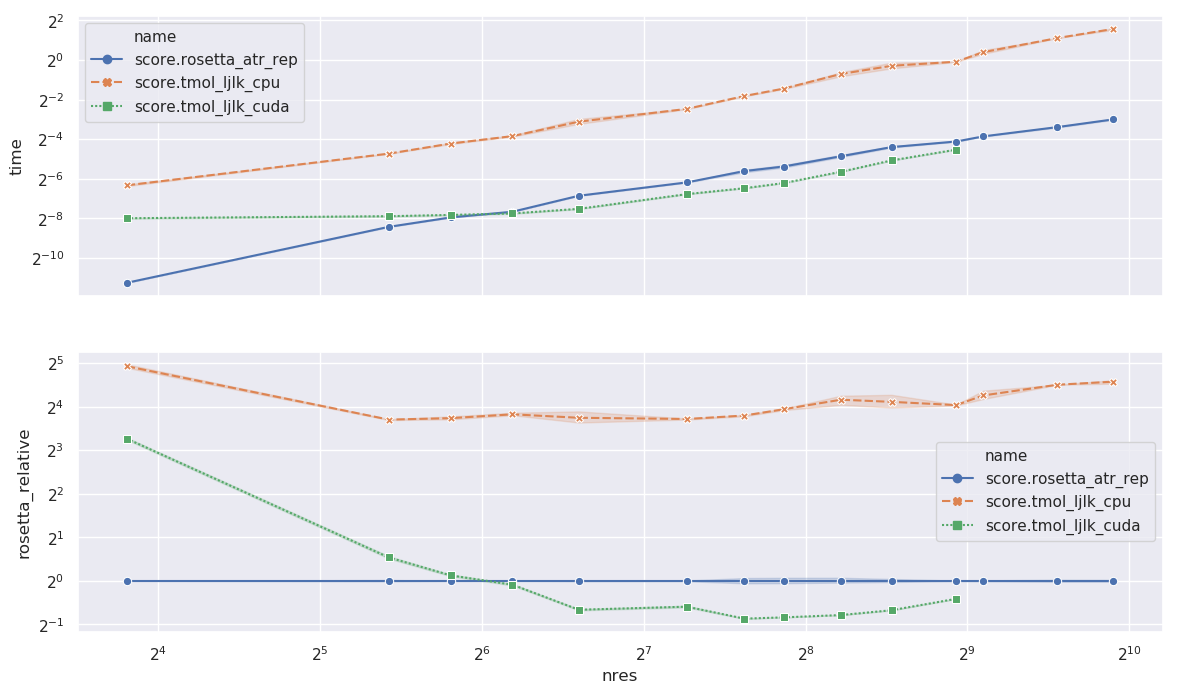

In [25]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "time", data=dat, hue="name", style="name", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "rosetta_relative", data=dat, hue="name", style="name", markers=True)